# Dataset banking : Octroi d'un crédit bancaire

Dans cet exercice nous souhaitons équilibrer les chances d'obtention d'un crédit quelle que soit la qualité du demandeur.  
Pour ce faire, nous allons :
- identifier le biais dans le jeu de données utilisé pour entraîner notre algorithme d'IA ;
- l'étudier pour le traiter et transformer le jeu de données en un jeu susceptible d'établir une forme d'équité, que l'on appelle généralement **fairness** ;
- et finalement nous allons tester notre modèle et de l'évaluer.

---

# Importation des librairies

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


---

# Analyse Exploratoire des Données (a.k.a. Exploratory Data Analysis)

L'objectif de cette section est de comprendre le jeu de données mis à disposition\nLes étapes générales à suivre sont :
- visualiser le dataset ;
- supprimer les observations contenant des valeurs anormales (e.g. NaN, etc) ;
- lister les colonnes ;
- lister la nature des variables ;
- etc.

In [3]:
df = pd.read_csv('./banking_data.csv', sep = ';')
df = df.dropna()
print(df.shape)
print(list(df.columns))

(45211, 10)
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'previous', 'y']


**Objectif :** Chercher dans un premier temps les variables qui présentent un désequilibre dans leur répartition.

Nous allons nous foclaliser sur la variable "marital" :
- déterminez les valeurs uniques de cette variable ;
- faites un *count* sur ces valeurs afin de voir leur répartition et éventuellement constater un désequilibre.


In [5]:
df['marital'].unique()

array(['married', 'single', 'divorced'], dtype=object)

In [6]:
df['marital'].value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

In [7]:
df.head(5)

,age,job,marital,education,default,balance,housing,loan,previous,y
0,58,management,married,tertiary,no,2143,yes,no,0,no
1,44,technician,single,secondary,no,29,yes,no,0,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,0,no
3,47,blue-collar,married,unknown,no,1506,yes,no,0,no
4,33,unknown,single,unknown,no,1,no,no,0,no


In [8]:
#del df['Unnamed: 0']
df['y'] =pd.Series(np.where(df.y.values == "yes", 1, 0), df.index)
df.head(10)

,age,job,marital,education,default,balance,housing,loan,previous,y
0,58,management,married,tertiary,no,2143,yes,no,0,0
1,44,technician,single,secondary,no,29,yes,no,0,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,0,0
3,47,blue-collar,married,unknown,no,1506,yes,no,0,0
4,33,unknown,single,unknown,no,1,no,no,0,0
5,35,management,married,tertiary,no,231,yes,no,0,0
6,28,management,single,tertiary,no,447,yes,yes,0,0
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,0,0
8,58,retired,married,primary,no,121,yes,no,0,0
9,43,technician,single,secondary,no,593,yes,no,0,0


---

# EDA Biais

Déterminer la proportion des valeurs (married et single) de la variable \"marital\" par rapport à la colonne cible *y*.

In [9]:
agg_marital = df[['marital', 'y']].groupby('marital').mean()
print(agg_marital.round(3))

              y
marital        
divorced  0.119
married   0.101
single    0.149


Une bonne représentation est souvent plus explicite qu'un (long ou petit) paragraphe, nous alons donc :
- tracer ces proportions sous la forme d'un barplot ;
- tracer sur ce même graphe une ligne en pointillée indiquant la moyenne d'acceptation du credit.


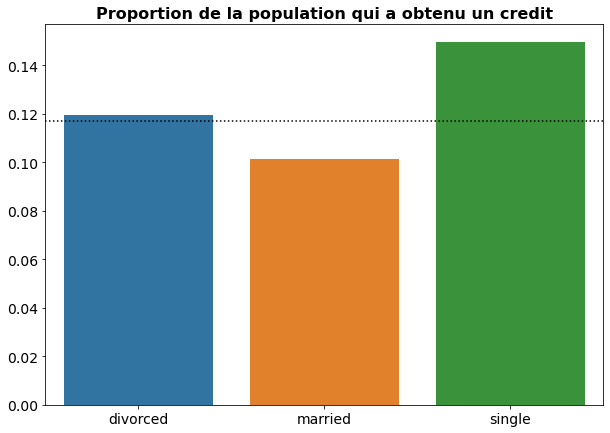

In [10]:
mean_get_loan = df['y'].mean()

fig, ax1 = plt.subplots(figsize=(10, 7))
sns.barplot(x=agg_marital.index, y=agg_marital.y, ax=ax1).\
set_title('Proportion de la population qui a obtenu un credit', fontsize=16, fontweight='bold')
ax1.axhline(mean_get_loan, color='k', linestyle=':')
ax1.set(xlabel='', ylabel='')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

Quelle est la valeur de cette moyenne ?

In [12]:
print(mean_get_loan)#.round(3))

0.11698480458295547


Expliquer briévement la signification de ce seuil.

**==> Les celibataires ont une probabilité supérieure à la moyenne d'obtenir un credit, tandis que les marriés ont une probabilité inférieure à la moyenne d'obtenir un credit.**


---

# Introduction de la librairie AIF360

Pour pouvoir utiliser la librairie AIF360, il faut convertir les données dans le format adéquat.  
La première étape consiste à identifier les **variables catégorielles** et les distinguer des **variables numériques**, pour ensuite effectuer une **transformation OneHotEncoding** sur les premières.

Conversion du dataset au format aif360: 
- Faite du OnhotEncoding sur les variables categorielle
- job,education,default,housing,loan, marital

In [13]:
df.head(10)

,age,job,marital,education,default,balance,housing,loan,previous,y
0,58,management,married,tertiary,no,2143,yes,no,0,0
1,44,technician,single,secondary,no,29,yes,no,0,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,0,0
3,47,blue-collar,married,unknown,no,1506,yes,no,0,0
4,33,unknown,single,unknown,no,1,no,no,0,0
5,35,management,married,tertiary,no,231,yes,no,0,0
6,28,management,single,tertiary,no,447,yes,yes,0,0
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,0,0
8,58,retired,married,primary,no,121,yes,no,0,0
9,43,technician,single,secondary,no,593,yes,no,0,0


In [14]:
var_numerique = ["age","balance","previous", "y"]
var_categorielle = ["job","education","default","housing","loan", "marital"]

In [15]:

df_onehot = pd.concat([df[var_numerique], pd.get_dummies(df[var_categorielle])], axis=1)


In [16]:
df_onehot.head(5)

,age,balance,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,marital_divorced,marital_married,marital_single
0,58,2143,0,0,0,0,0,0,1,0,...,0,1,0,0,1,1,0,0,1,0
1,44,29,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,0,1
2,33,2,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,1,0,1,0
3,47,1506,0,0,0,1,0,0,0,0,...,1,1,0,0,1,1,0,0,1,0
4,33,1,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,0,0,0,1


---

Pour définir le biais on va considérer la variable "marital" et on va se concentrer sur la valeur "marital_married" créée suite au One Hot Encoding. Donc, pour construire l'algorithme de prédiction des accords de prêt, nous allons :
- considérer une labelisation binaire (i.e. le statut est soit celibataire, soit marié) et définir un **groupe de privilégiés** et un **groupe de non-privilégiés** ;
- convertir les données en un BinaryLabelDataset (de AIF360) ;
- garder seulement l'attribut "marital_married", car c'est elle qui représente un biais significatif ; donc nous supprimons les colonnes marital_single et marital_divorced.


In [17]:
df_aif = BinaryLabelDataset(df=df_onehot.drop(['marital_single','marital_divorced'], axis=1), \
                            label_names=['y'], protected_attribute_names=['marital_married'])
print(df_aif)

               instance weights features                              \
                                                                       
                                     age balance previous job_admin.   
instance names                                                         
0                           1.0     58.0  2143.0      0.0        0.0   
1                           1.0     44.0    29.0      0.0        0.0   
2                           1.0     33.0     2.0      0.0        0.0   
3                           1.0     47.0  1506.0      0.0        0.0   
4                           1.0     33.0     1.0      0.0        0.0   
...                         ...      ...     ...      ...        ...   
45206                       1.0     51.0   825.0      0.0        0.0   
45207                       1.0     71.0  1729.0      0.0        0.0   
45208                       1.0     72.0  5715.0      3.0        0.0   
45209                       1.0     57.0   668.0      0.0       

In [18]:
privileged_group = [{'marital_married': 0}]
unprivileged_group = [{'marital_married': 1}]

Division du dataset entre les ensembles de *train*, de *test* et de *validation*

In [19]:
df_orig_trn, df_orig_val, df_orig_tst = df_aif.split([0.5, 0.8], shuffle=True)
print([x.features.shape for x in [df_orig_trn, df_orig_val, df_orig_tst]])

[(22605, 26), (13563, 26), (9043, 26)]


---

On va maintenant choisir une **fairness metric** et l'appliquer sur l'ensemble du jeu de données.

Ces métriques font référence aux diverses tentatives de correction des biais algorithmiques dans les processus automatisés de décision basés sur des modèles d'apprentissage automatique.

Il existe différentes mesures de fairness dans AIF360, mais ici nous allons nous concentrer sur la **disparate impact (DI)**. Il s'agit de la probabilité de succès étant donné que le demandeur de prêt est non privilégié (i.e. marié ici), divisée par la probabilité de succès étant donné que le demandeur de prêt est privilégié (i.e. célibataire ici). Et nous reformulons notre **indice de référence d'équité** en : **1 - min(DI, 1/DI)**.  
Si le DI venait à être supérieur à 1, cela signifierait que le groupe privilégié est désavantagé.

Pour notre indice de référence d'équité, nous exigeons que **1 - min(DI, 1/DI) < 0,2** (critère d'acceptabilité).

In [20]:
metric_orig_trn = BinaryLabelDatasetMetric(df_orig_trn, unprivileged_group, privileged_group)


def get_disparity_index(di):
    return 1 - np.minimum(di, 1 / di)


print('1-min(DI, 1/DI):', get_disparity_index(metric_orig_trn.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.273


Cette valeur de l'indice confirme que l'ensemble de données d'origine est biaisé.

Si la valeur de l'indice était proche de 0, il n'y aurait pas de biais (selon cette métrique et sur cette variable). Ce n'est pas le cas ici

---

# Entraîner un modèle et mesurer le biais

Nous allons construire un classifieur sous la forme d'une régression logistique.

In [21]:
def train_lr_model(dataset):
    scale = StandardScaler().fit(dataset.features)
    model = LogisticRegression(random_state=0, solver='liblinear')
    x_train = scale.transform(dataset.features)
    y_train = dataset.labels.ravel()
    model.fit(x_train, y_train, sample_weight=dataset.instance_weights)
    y_train_pred = model.predict(x_train)
    return model, scale

In [22]:
lr_orig, lr_scale_orig = train_lr_model(df_orig_trn)

---

À partir de là, notre objectif est de :
- construire la modélisation qui donne la meilleure accuracy ;
- calculer le biais tout au long de l'entraînement pour à terme le comparer à l'accuracy.

In [23]:
thresh_arr = np.linspace(0.01, 0.5, 100)


def get_y_pred_prob_lr(scale, model, dataset):
    x = scale.transform(dataset.features)
    y_pred_prob = model.predict_proba(x)
    return y_pred_prob


y_validate_pred_prob_orig = get_y_pred_prob_lr(scale=lr_scale_orig, model=lr_orig, dataset=df_orig_val)


def get_bal_acc(classified_metric):
    return 0.5 * (classified_metric.true_positive_rate() + classified_metric.true_negative_rate())


def get_best_bal_acc_cutoff(y_pred_prob, dataset):
    y_validate_pred_prob = y_pred_prob
    bal_acc_arr = []
    disp_imp_arr = []

    for thresh in tqdm(thresh_arr):
        y_validate_pred = (y_validate_pred_prob[:, 1] > thresh).astype(np.double)
        dataset_pred = dataset.copy()
        dataset_pred.labels = y_validate_pred

        # Calculate accuracy for each threshold value
        classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)
        bal_acc = get_bal_acc(classified_metric)
        bal_acc_arr.append(bal_acc)

        # Calculate fairness for each threshold value
        metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_group, privileged_group)
        disp_imp_arr.append(metric_pred.disparate_impact())

    # Find threshold for best accuracy
    thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
    thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

    # Calculate accuracy and fairness at this threshold
    best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
    disp_imp_at_best_bal_acc = disp_imp_arr[thresh_arr_best_ind]

    # Output metrics
    acc_metrics = pd.DataFrame({'thresh_arr_best_ind': thresh_arr_best_ind, \
                                'thresh_arr_best': thresh_arr_best, \
                                'best_bal_acc': best_bal_acc, \
                                'disp_imp_at_best_bal_acc': disp_imp_at_best_bal_acc}, index=[0]).transpose()
    return acc_metrics, bal_acc_arr, disp_imp_arr, dataset_pred.labels


acc_metrics_orig, bal_acc_arr_orig, disp_imp_arr_orig, dataset_pred_labels_orig = \
    get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_orig, dataset=df_orig_val)

print('Threshold corresponding to best balanced accuracy:', acc_metrics_orig.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_orig.loc['best_bal_acc', 0].round(3))




100%|██████████| 100/100 [00:00<00:00, 187.53it/s]

Threshold corresponding to best balanced accuracy: 0.134
Best balanced accuracy: 0.635


In [24]:
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_orig.loc['disp_imp_at_best_bal_acc', 0]).round(3))

1-min(DI, 1/DI): 0.462


Expliquer le résultat obtenu

**==> Cela montre que le seuil avec la meilleure précision est de 0,129. À ce seuil, notre métrique de précision (précision équilibrée) est de 0,642, mais notre métrique d'équité (1-min(DI, 1/DI)) est de 0,424, ce qui indique un biais. Nous pouvons tracer ces mesures de précision et d'équité sur une plage de seuils de classification :**
**+ On remarque aussi que meme avec la determination du meilleur seuil statistique et meilleur accuracy, il y a un biais. (calculé par le disparate impact)**

---

Pour vérifier visuellement les performances du modèle, nous allons tracer les courbes suivantes :
- Accuracy * Seuil
- DI * Seuil

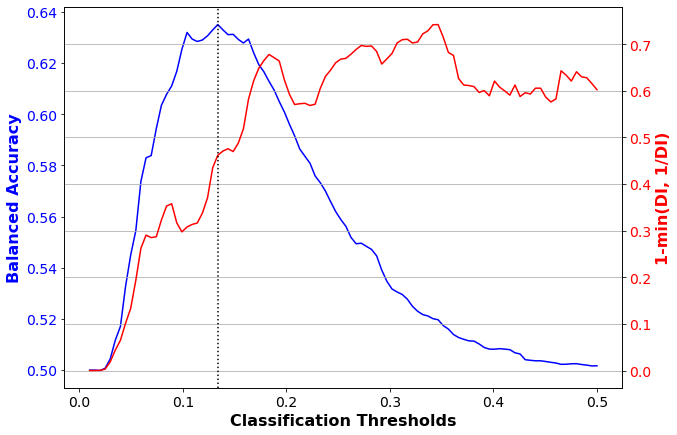

In [25]:

def plot_acc_vs_fairness(metric, metric_name, bal_acc_arr, thresh_arr_best_ind):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(thresh_arr, bal_acc_arr, color='b')
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14, labelcolor='b')
    ax2 = ax1.twinx()
    ax2.plot(thresh_arr, metric, color='r')
    ax2.set_ylabel(metric_name, color='r', fontsize=16, fontweight='bold')
    ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14, labelcolor='r')
    ax2.grid(True)


plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_orig)), \
                     '1-min(DI, 1/DI)', bal_acc_arr_orig, \
                     acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))

Interpréter la signification des deux courbes

**==> On vois sur la courbe que la meilleur accuracy trouvé est le pique en bleu, qui corresponde au seuil (Threshol associé de 0.129)
Dans la courbe rouge, on vois si on réequilibre à 0.129, le biais sera de 0.424, ce qui est un biais énorme**

---

Tester alors ces trois métriques (accuracy, seuil et DI) sur le jeu de test.

In [26]:
y_test_pred_prob_orig = get_y_pred_prob_lr(scale=lr_scale_orig, model=lr_orig, dataset=df_orig_tst)


def test_lr_model(y_data_pred_prob, dataset, thresh_arr):
    y_pred = (y_data_pred_prob[:, 1] > thresh_arr).astype(np.double)
    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_group, privileged_group)
    return dataset_pred.labels, classified_metric, metric_pred


dataset_pred_labels_orig, classified_metric_orig, metric_pred_orig = test_lr_model( \
    y_data_pred_prob=y_test_pred_prob_orig, dataset=df_orig_tst, \
    thresh_arr=acc_metrics_orig.loc['thresh_arr_best', 0])

print('Threshold corresponding to best balanced accuracy:', acc_metrics_orig.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', get_bal_acc(classified_metric_orig).round(3))
print('1-min(DI, 1/DI):', get_disparity_index(metric_pred_orig.disparate_impact()).round(3))

Threshold corresponding to best balanced accuracy: 0.134
Best balanced accuracy: 0.647
1-min(DI, 1/DI): 0.436


Expliquer les résultats

**==> Comme pour l'ensemble de données de validation, nous nous retrouvons avec une bonne précision, mais une mauvaise métrique de Fairness. Cela montre que si nous ne considérons que la précision (comme c'est souvent le cas dans de nombreuses organisations), nous nous retrouvons avec un modèle biasé.**

---

# Calibrage des données

Pour traiter le biais, on va transformer le jeu de donnée par la technique de "Reweighing". Celle-ci attribue des pondérations adaptées aux différentes classes de la population pour garantir leur fairness.

In [27]:
RW = Reweighing(unprivileged_group, privileged_group)
df_transf_trn = RW.fit_transform(df_orig_trn)

---

# Calcul de la fairness metric sur le jeu de données transformé

In [28]:
metric_transf_trn = BinaryLabelDatasetMetric(df_transf_trn, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_transf_trn.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.0


Que remarquez-vous ?

**==> Lorsque nous calculons la métrique d'équité sur l'ensemble de données transformé, nous constatons qu'il est équitable.**

---

# Entrainer un modèle sur le jeu de données débiaisé (i.e. équilibré)

Réentraîner le modèle sur le jeu de données transformé, et réévaluer l'ensemble des métriques.

In [29]:
lr_transf, lr_scale_transf = train_lr_model(df_transf_trn)

In [30]:
y_validate_pred_prob_transf = get_y_pred_prob_lr(scale=lr_scale_transf, model=lr_transf, dataset=df_orig_val)
acc_metrics_transf, bal_acc_arr_transf, disp_imp_arr_transf, dataset_pred_labels_transf = \
    get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_transf, dataset=df_orig_val)

print('Threshold corresponding to best balanced accuracy:', acc_metrics_transf.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_transf.loc['best_bal_acc', 0].round(3))
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_transf.loc['disp_imp_at_best_bal_acc', 0]).round(3))


100%|██████████| 100/100 [00:00<00:00, 191.37it/s]

Threshold corresponding to best balanced accuracy: 0.149
Best balanced accuracy: 0.631
1-min(DI, 1/DI): 0.097


Expliquer le résultat.

**==> Cela montre que le seuil avec la meilleure précision est de 0,144. À ce seuil, notre métrique de précision (précision équilibrée) est de 0,637, et notre métrique d'équité (1-min(DI, 1/DI)) est de 0,056, ce qui n'indique aucun biais.**

Tracer l'ensemble des mesures de précision et de DI sur une plage de seuils de classification.

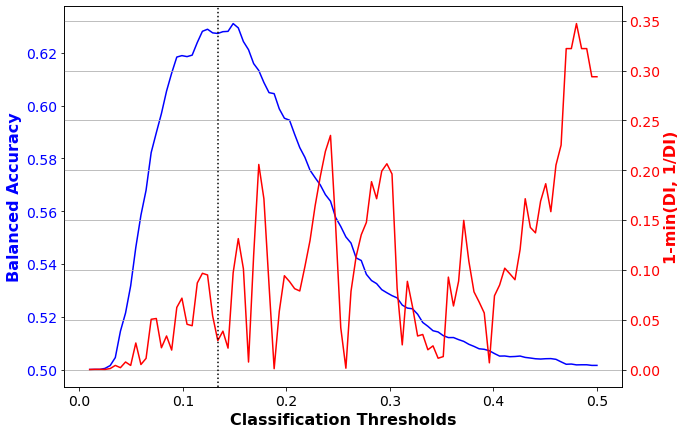

In [31]:
plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_transf)), \
  '1-min(DI, 1/DI)', bal_acc_arr_transf, \
  acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))

Interpréter les courbes.

**- On vois sur la courbe que la meilleur accuracy trouvé est le pique en bleu 0.637, qui corresponde au seuil (Threshol associé de 0.144)**
**- Dans la courbe rouge, on vois si on réequilibre à ce seuil 0.144, le biais sera de 0.056, ce qui est un biais acceptable**

---

# Tester le modèle sur le jeu de données débiaisé (i.e. equilibré)

In [32]:
y_test_pred_prob_transf = get_y_pred_prob_lr(scale=lr_scale_transf, model=lr_transf, dataset=df_orig_tst)

dataset_pred_labels_transf, classified_metric_transf, metric_pred_transf = test_lr_model(\
  y_data_pred_prob=y_test_pred_prob_transf, dataset=df_orig_tst,\
  thresh_arr=acc_metrics_transf.loc['thresh_arr_best', 0])

print('Threshold corresponding to best balanced accuracy:', acc_metrics_transf.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', get_bal_acc(classified_metric_transf).round(3))
print('1-min(DI, 1/DI):', get_disparity_index(metric_pred_transf.disparate_impact()).round(3))

Threshold corresponding to best balanced accuracy: 0.149
Best balanced accuracy: 0.64
1-min(DI, 1/DI): 0.063


Interpréter le résultat

**Comme pour l'ensemble de données de validation, nous nous retrouvons avec une bonne métrique de précision et de fairness. L'atténuation du biais a entraîné une légère détérioration de la précision (de 0,634 à 0,633), mais une amélioration considérable de l'équité (0,511 à 0,107). Cela montre que des modèles à la fois précis et justes peuvent être construits sur des données biaisées, à condition que l'atténuation des biais soit appliquée de manière appropriée.**

---

# Conclusion

Nous avons vu ici comment un ensemble de données avec un biais historique induit des modèles biaisés qui produisent des résultats injustes.  
Dans notre scénario, les prêts sont plus favorablement accordés aux celibataires, car ils ont toujours été plus susceptibles d'en obtenir. Ceci découle directement du fait que les techniques d'apprentissage automatique traditionnelles optimisent uniquement la précision, et non pas l'équité. Nous avons également vu qu'en appliquant des techniques simples d'atténuation des biais, nous pouvons supprimer le déséquilibre de l'ensemble de données et ainsi créer des modèles avec une précision comparable, mais des mesures d'équité bien meilleures.  
Ces techniques de détection et d'atténuation des biais sont très pertinentes pour toute organisation cherchant à automatiser la prise de décision sur des populations aux attributs protégés.